In [1]:
#Throughout this document, things that can be changed by the user to investigate different 
#parts of the map are marked with #FINDME

# Import functions
import numpy as np
import matplotlib.pyplot as p
%matplotlib inline

import eigencurves_starry
import eigenmaps
import kmeans
import bin_eigenspectra
import os
import pdb
import spiderman as sp

import gen_lightcurves
import healpy as hp

import colorcet as cc
from colormap2d import generate_map2d
from matplotlib import colorbar, cm
from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
p.rc('text', usetex=True)
p.rc('font', family='serif')

import run_higher_sph_harm
from eigensource import plot_utils#_meganedited
from eigensource import plot_utils_meganedited

from importlib import import_module
planet_name = 'HD189733b'
model_name = "asym2" #FINDME: name of the model to perform the fit from
filename='data/input_lightcurves/'+model_name+'.npz' #FINDME: for the mystery maps, uncomment this line and skip directly to section "Perform Inference" 

looking for spidermanrc file at /Users/megan/.spidermanrc


Set the Wavelength Grid

In [ ]:
lammin = 2.41
lammax = 3.98

lamhr = np.linspace(lammin, lammax, 1000)

# Use `gen_lightcurves.spec_flat_with_gaussian()` to generate toy mock spectra

In [ ]:
f1 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.002, B = 0.001, std = 0.02, xroll = -0.20)
f2 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.003, B = 0.001, std = 0.02, xroll = 0.0)  
f3 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.004, B = 0.001, std = 0.02, xroll = 0.20) 
f4 = gen_lightcurves.spec_flat_with_gaussian(lamhr, A = 0.005, B = 0.001, std = 0.02, xroll = 0.40) 


p.plot(lamhr, f1)
p.plot(lamhr, f2)
p.plot(lamhr, f3)
p.plot(lamhr, f4)
p.xlabel("Wavelength [$\mu$m]")
p.ylabel("Fp/Fs")

# Use `gen_lightcurves.create_quadrant_map()` to paint the spectra onto the planet map

In [ ]:
spaxels = gen_lightcurves.create_quadrant_map(f4, f4, f1, f1)
print(np.shape(spaxels))#3072
print(np.shape(f1))
plot_utils.show_orig_map(lamhr, spaxels);

# Generate new input lightcurves

In [ ]:
# Generate the multi-wavelength eclipse lightcurves using starry
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, 
                                                                          plot_lightcurves = True, 
                                                                          plot_diagnostic = True, 
                                                                          plot_points_on_map_spec=True)

# Save as a .npz file in data/input_lightcurves
filename='data/input_lightcurves/'+model_name+'.npz'
np.savez(filename,time=time,wl=lam,dwl=dlam,lightcurve=lcurves)

# Perform inference
This can take a while, but the results will be saved for faster future runs.

In [2]:
## Results are saved in data/sph_harmonic_coefficients_full_samples
for oneOrd in np.arange(3,4): #FINDME: replace arange with degrees of spherical harmonics you want to create fits for
    run_higher_sph_harm.run_lc_noise_and_fit(norder=oneOrd,usePath=filename,afew=4)
#FINDME: afew=5 sets the number of eigencurves to include when fitting the maps.
#Setting afew to an integer between 1 and 10 will fit for that number of eigencurves exactly.
#If you set afew>2*(degree)^2, the code will fit for the correct number of eigencurves based on the BIC.
#If you select to fit for the number of eigencurves, the code will print out how many eigencurves were used for each wavelength.
#This routine saves a dictionary under the path data/sph_harmonic_coefficients_full_samples/modelname/spherearray_deg_oneOrd.npz
#Dictionary contains the following keywords:
# 1. wavelength (um): list of wavelengths
# 2. spherical coefficients: coefficients from each step in the MCMC
# 3. best fit coefficients: coefficients from the step with the lowest chi-squared
# 4. N Params Used: number of parameters in the fit at each wavelength (note that this number is 2 MORE than the number of eigencurves used)
# 5. ecoeffList: For each wavelength, lists coefficients for converting from spherical harmonics into eigencurves
# 6. escoreList: Lists the eigencurves for each wavelength
# 7. elc: Lists lightcurves corresponding to individual spherical harmonic terms (i.e. the input into the PCA to get the eigencurves; same for all wavelengths)


Found the previously-run file data/sph_harmonic_coefficients_full_samples/asym2/spherearray_deg_3.npz. Now exiting


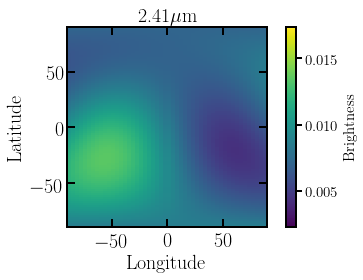

In [3]:
dataDir='data/sph_harmonic_coefficients_full_samples/'+model_name+'/'
waves, lats, lons = plot_utils.get_map_and_plot(waveInd=0,degree=3,dataDir=dataDir,isspider=False,saveName='asym2_eigen4_starry')
#FINDME: using a different waveInd will show maps at a different wavelength
#using a different degree will show a fit with a different number of spherical harmonics
#isspider=False uses Arthur's implementation of converting from lightcurves to maps (faster than the SPIDERMAN method and identical maps are produced)
#The middle map (labeled 50th percentile map) shows the single best-fit map with the lowest chi-squared

In [4]:
test=np.load(filename)
time=test['time']
#np.shape(maps)

In [5]:
degree=3 #FINDME: change this to investigate fits with different numbers of spherical harmonics
ngroups=2 #FINDME: change ngroups to cluster the data into a different number of eigengroups
extent=(np.max(time)-np.min(time))/2.21857567+180./360. #phase coverage of the eclipse observations
minlon=np.around(extent/2.*100)
clons=lons[:,int(100/2.-minlon):int(100/2.+minlon)]
clats=lats[:,int(100/2.-minlon):int(100/2.+minlon)]
eigenspectra_draws, kgroup_draws,uber_eigenlist, maps = plot_utils.find_groups(dataDir,degree=degree,trySamples=100,
                                                                ngroups=ngroups,extent=extent,isspider=False)
#FINDME: can change trySamples to set the number of MCMC draws you'd like to use to find the groups (larger number will make it run slower)

Find the eigenspectra and their errors

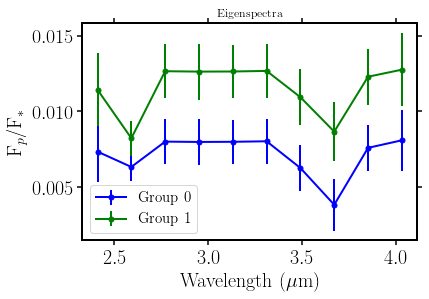

In [6]:
kgroups = plot_utils.show_spectra_of_groups(eigenspectra_draws,kgroup_draws,uber_eigenlist,waves,degree=degree,saveName='asym2_eigen4_starry')

## Show histograms of group assignments

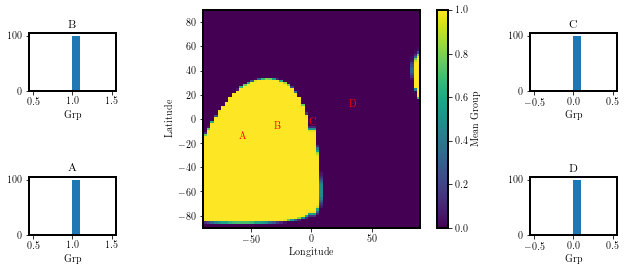

In [7]:
xLons= np.array([-60,-30,0,30]) * np.pi/180. #np.array([-50,-8,40,59])
xLats= np.array([-18,-9,-4,10]) * np.pi/180. #np.array([40,-10, 0,-59])
# xLons= np.array([-30]) * np.pi/180.
# xLats= np.array([45]) * np.pi/180.
saveName = 'plots/asym2_eigen4_starry_deg_{}_grp_{}.pdf'.format(degree,ngroups) #FINDME: change name to save under different filename
eigenmaps.show_group_histos(kgroups,lons,lats,kgroup_draws,
                            xLons=xLons,xLats=xLats,
                            saveName=saveName)

/Users/megan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/megan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/megan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


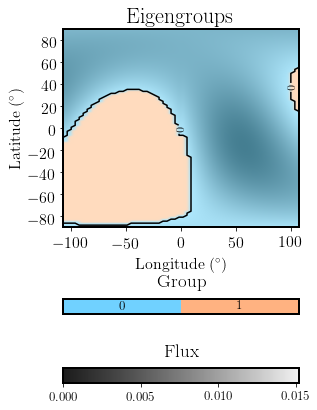

In [8]:
plot_utils_meganedited.do_hue_maps(extent,maps,lons,lats,kgroups,ngroups,degree,hueType='group',saveName='asym2_eigen4_starry')

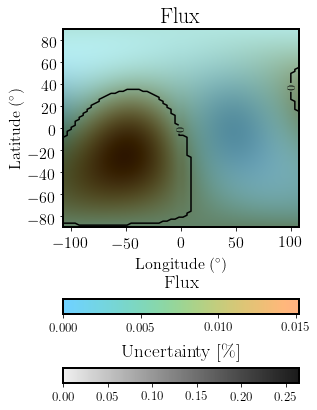

In [9]:
plot_utils_meganedited.do_hue_maps(extent,maps,lons,lats,kgroups,ngroups,degree,hueType='flux',saveName='asym2_eigen4_starry')